In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import torch
import torchvision
from torch import nn
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torchvision.models as models

In [0]:
# Set GPU
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


## Image categorizing requires following steps
1. load data
2. create a network (model)
3. define loss function
4. choose and set optimazer
5. training
6. prediction

## step1: Loading data

In [0]:
# data URL is hidden

--2020-01-25 09:55:06--  https://datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com/+day3/food_data.zip
Resolving datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com (datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com)... 52.219.0.167
Connecting to datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com (datamix-advance-deeplearning.s3-ap-northeast-1.amazonaws.com)|52.219.0.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208150490 (199M) [application/zip]
Saving to: ‘food_data.zip’

food_data.zip       100%[===================>] 198.51M  23.4MB/s    in 9.3s    

2020-01-25 09:55:16 (21.3 MB/s) - ‘food_data.zip’ saved [208150490/208150490]

Archive:  food_data.zip
   creating: food_data/
   creating: food_data/test/
   creating: food_data/test/test/
  inflating: food_data/test/test/1-23.jpg  
  inflating: food_data/test/test/1-8.jpg  
  inflating: food_data/test/test/3-26.jpg  
  inflating: food_data/test/test/4-13.jpg  
  

### Create dataloader
---
create dataloader to process images with for loops. 
datasets.ImageFolder returns a list of tuples which consist of (image, target label).

In [0]:
transform = transforms.Compose(
    [transforms.RandomResizedCrop(100, scale=(1.0, 1.0), ratio=(1.0, 1.0)), 
    transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])

imageset = datasets.ImageFolder(root='food_data/train',
                                transform=transform)

train_size = int(0.85 * len(imageset))
valid_size = len(imageset) - train_size
trainset, validset = torch.utils.data.random_split(
    imageset, [train_size, valid_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=32,
                                          shuffle=False)

In [0]:
print(len(imageset), train_size, valid_size)

2100 1785 315


In [0]:
classes = ['Bread', 'Dessert', 'Meat', 'Noodles-Pasta',  'Vegetable-Fruit']

(410, 818, 3)


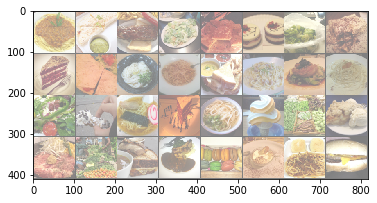

Noodles-Pasta Bread  Meat Vegetable-Fruit Bread Dessert Vegetable-Fruit Dessert Dessert Bread Noodles-Pasta Noodles-Pasta Bread Noodles-Pasta  Meat Noodles-Pasta Vegetable-Fruit Dessert Noodles-Pasta Dessert Noodles-Pasta Dessert Vegetable-Fruit Dessert  Meat Vegetable-Fruit Bread  Meat Dessert Dessert Noodles-Pasta Bread


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

## Step2:  Create network

In [0]:
# there are several network for image classification, this time, use resnet50
model_ft = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [0]:
for param in model_ft.parameters():
    param.require_grad = False

In [0]:
# Check in_features at fc layer of resnet. In this case 2048
model_ft.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [0]:
# change the in_features at fc at the end of resnet
model_ft.fc = nn.Linear(in_features=2048, out_features=len(classes), bias=True)

In [0]:
model_ft = model_ft.to(device)

## Step3: Define loss function

In [0]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

CrossEntropyLoss()


## Step4: Optimizer

In [0]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

## step5: Training

In [0]:
train_loss_track = []
test_loss_track = []

# by changing epoc_num you may get higher precision
epoc_num = 20

for epoc in range(epoc_num): 
    running_loss = 0
    running_test_loss = 0
    
    # set training mode
    model_ft.train()
    for step, (xx, yy)  in enumerate(trainloader):
        
        # send data to GPU if device = "cuda"
        xx = xx.to(device)
        yy = yy.to(device)
        
        # initialing previous calculated parameters
        optimizer.zero_grad()
        
        # foward propagation
        y_pred = model_ft(xx)
        
        # calculate loss
        loss = loss_func(y_pred, yy)
        
        # back propagation (auto-tuning parameters)
        loss.backward()
        
        # reset parmeters
        optimizer.step()
        
        # calculate loss
        running_loss += loss.item()
        
        # Verbose (outputting training status)
        if step % 100 == 0:
            print('[{:d}, {:5d}] loss: {}'
                    .format(epoc + 1, step + 1, running_loss / 100))
            running_loss = 0.0
        
    # calculate loss function at the end
    train_loss_track.append(running_loss/step)
    
    
    # switch to evaluation mode
    model_ft.eval()
    
    with torch.no_grad():
        for step, (xx_test, yy_test)  in enumerate(validloader):
            
            xx_test = xx_test.to(device)
            yy_test = yy_test.to(device)

            y_pred = model_ft(xx_test)

            test_loss = loss_func(y_pred, yy_test)

            running_test_loss += test_loss.item()
            
        test_loss_track.append(running_test_loss / (step + 1))

[1,     1] loss: 0.016485159397125245
[2,     1] loss: 0.012533541917800903
[3,     1] loss: 0.011922616958618164
[4,     1] loss: 0.00900378167629242
[5,     1] loss: 0.008791667222976685
[6,     1] loss: 0.008256621360778808
[7,     1] loss: 0.0048303833603858945
[8,     1] loss: 0.005142508745193481
[9,     1] loss: 0.00411213755607605
[10,     1] loss: 0.0048039740324020384
[11,     1] loss: 0.004135470390319824
[12,     1] loss: 0.004340651631355286
[13,     1] loss: 0.0040430337190628055
[14,     1] loss: 0.003915219902992249
[15,     1] loss: 0.0022893133759498596
[16,     1] loss: 0.002095185965299606
[17,     1] loss: 0.0015953224897384643
[18,     1] loss: 0.0010338862240314483
[19,     1] loss: 0.0008090011775493622
[20,     1] loss: 0.001638132780790329


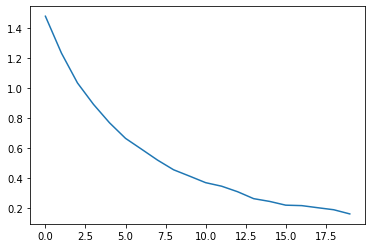

In [0]:
# plotting loss on train
plt.plot(train_loss_track)

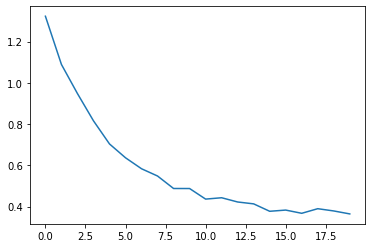

In [0]:
# plotting loss on test
plt.plot(test_loss_track)

In [0]:
# calculate Accuracy
true = 0
total = 0

all_labels = np.array([])
all_preds = np.array([])

with torch.no_grad():
    for test_xx, test_yy in validloader:
        
        test_xx = test_xx.to(device)
        test_yy = test_yy.to(device)

        outputs = model_ft(test_xx)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels = np.append(all_labels, test_yy.cpu().data.numpy())
        all_preds = np.append(all_preds, predicted.cpu().numpy())
        
        total += test_yy.size(0)
        true += (predicted == test_yy).sum().item()
print('Accuracy: {:.2f} %'.format(100 * float(true/total)))

Accuracy: 86.67 %


## step6: prediction

In [0]:
testset = datasets.ImageFolder(root='food_data/test',
                               transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

In [0]:
all_preds = []

with torch.no_grad():
    for test_xx, test_yy in testloader:
        
        test_xx = test_xx.to(device)

        outputs = model_ft(test_xx)
        _, predicted = torch.max(outputs.data, 1)

        all_preds = np.append(all_preds, predicted.cpu().numpy())

all_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 2., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 4., 1.,
       1., 0., 1., 2., 1., 1., 1., 1., 4., 1., 0., 1., 1., 1., 1., 1., 4.,
       1., 1., 1., 1., 4., 1., 1., 1., 1., 2., 2., 1., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 2., 4., 2.,
       2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1., 3., 3., 3., 3., 3., 3.,
       3., 4., 4., 2., 4., 4., 4., 4., 0., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 0., 1., 4., 4., 4., 4., 4., 4.])

In [0]:
filename = "randomhorizontal_resne50_batchsize32_lr0.001_SDG_epoch20_cnn_submission.csv"
submissions = pd.DataFrame({"Id": list(range(1, len(all_preds)+1)),
                            "Label": all_preds})
submissions.to_csv(filename, index=False, header=True)

In [0]:
from google.colab import files
files.download(filename)